In [5]:
import os,sys,dateutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import IPython.display as ipydis

In [9]:
filename = os.environ['HOME'] + '/ping.log'

/Users/jchilders/ping.log


In [113]:
def parse_log(filename):
  print(filename)
  df = pd.DataFrame()
  df['timestamp'] = []
  df['icmp_seq'] = []
  df['ttl'] = []
  df['ping_time'] = []
  df['host_unreachable'] = []
  df['timeout'] = []
  for i,line in enumerate(open(filename)):
    try:
      csplit = line.split(':')
      if 'Destination Host Unreachable' in line or 'Destination Net Unreachable' in line:
        df = df.append({
          'timestamp': dateutil.parser.parse(':'.join(csplit[0:3])),
          'icmp_seq': 0,
          'ttl': 0,
          'ping_time': 0,
          'host_unreachable': 1,
          'timeout': 0,
        },ignore_index=True)
      elif 'Request timeout for' in line:
        df = df.append({
          'timestamp': dateutil.parser.parse(':'.join(csplit[0:3])),
          'icmp_seq': 0,
          'ttl': 0,
          'ping_time': 0,
          'host_unreachable': 0,
          'timeout': 1,
        },ignore_index=True)
      elif len(csplit) == 5:
        if 'PING' in csplit[3]: continue
        data = {'timestamp': dateutil.parser.parse(':'.join(csplit[0:3]))}
        stat_split = csplit[4].split()
        data['icmp_seq'] = int(stat_split[0].split('=')[1])
        data['ttl'] = int(stat_split[1].split('=')[1])
        data['ping_time'] = float(stat_split[2].split('=')[1])
        data['host_unreachable'] = 0
        data['timeout'] = 0
        df = df.append(data,ignore_index=True)
    except:
      print('failed to parse: ',line)
      raise
  return df
      

In [156]:
df = parse_log(filename)

/Users/jchilders/ping.log


In [110]:
#df.to_csv('/Users/jchilders/2020-03-20.ping.csv')

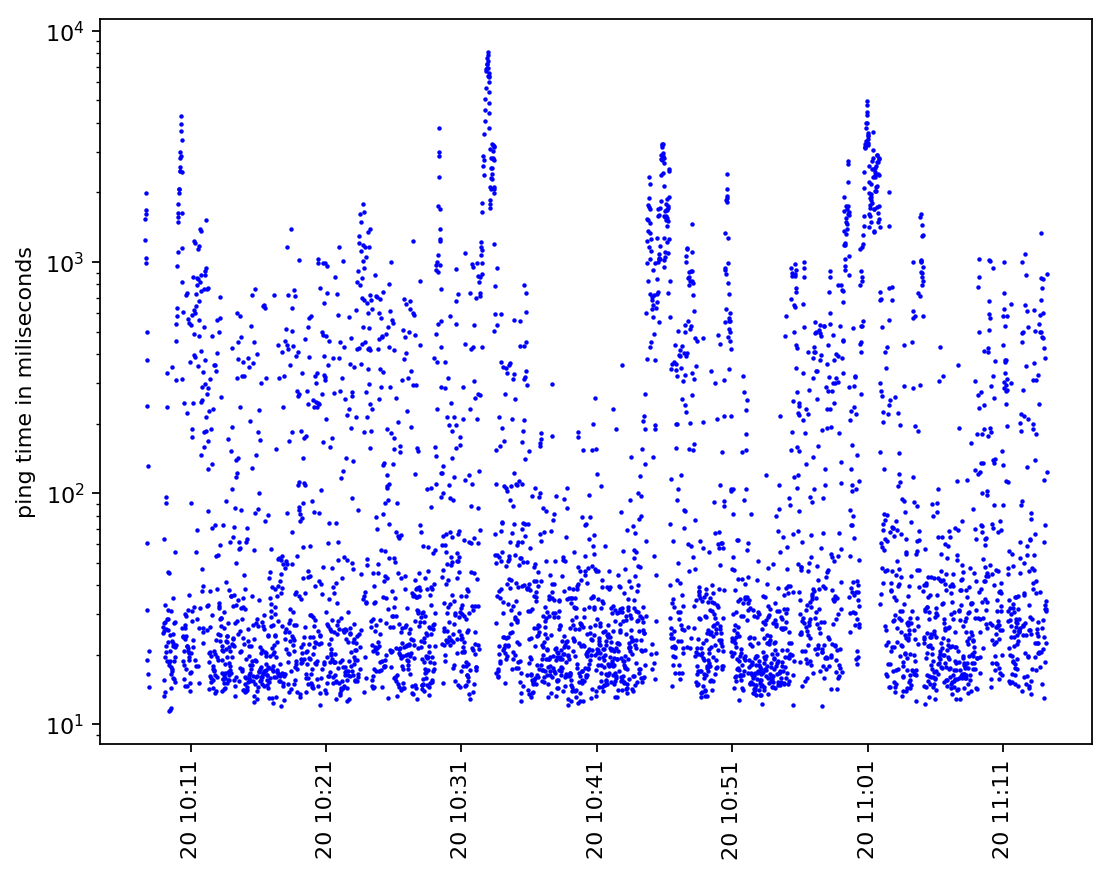

In [157]:
fig,ax = plt.subplots(figsize=(8,6),dpi=160)
ax.plot_date(df['timestamp'],df['ping_time'],markersize=1,fmt='bo')
timeouts = df[df['timeout'] == 1]
ax.plot_date(timeouts['timestamp'],timeouts['ping_time'],markersize=2,fmt='rs')
host_unreachable = df[df['host_unreachable'] == 1]
ax.plot_date(host_unreachable['timestamp'],host_unreachable['ping_time'],markersize=2,fmt='gs')
ax.set_ylabel('ping time in miliseconds')
ax.set_yscale('log')
plt.xticks(rotation='vertical')
plt.show()

In [103]:
ping_time = df[df['ping_time'] > 0]

In [108]:
ping_time['timestamp'].max()

Timestamp('2020-03-20 08:44:06-0500', tz='tzlocal()')

In [143]:
def get_bin_edges_datetime(x,bins=100):
  lowest = x.min()
  highest = x.max()
  total_duration = highest - lowest
  bin_size = total_duration / bins
  bin_edges = [lowest]
  for i in range(1,bins+1):
    bin_edges.append(bin_edges[-1] + bin_size)
  
  return bin_edges

In [147]:
be = get_bin_edges_datetime(df['timestamp'])
print(len(be))

101


In [145]:
def get_profile_timeseries(x_data,y_data,bins=100):
  bin_edges = get_bin_edges_datetime(x_data,bins)
  sum = 0.
  sum2 = 0.
  n = 0
  bin_counter = 0
  assert(len(x_data) == len(y_data))
  
  bdf = pd.DataFrame()
  bdf['timestamp'] = []
  bdf['mean'] = []
  bdf['stdev'] = []
  
  for i in range(len(x_data)):
    x = x_data[i]
    y = y_data[i]
    if x > bin_edges[bin_counter+1]:
      # reached the end of a bin, calculate mean/stdev and add to list
      bdf = bdf.append({
        'timestamp': bin_edges[bin_counter] + ((bin_edges[bin_counter+1] - bin_edges[bin_counter]) / 2.),
        'mean': sum / n,
        'stdev': np.sqrt((1 / n) * sum2 - (sum / n)**2 ),
      },ignore_index=True)
      sum = 0.
      sum2 = 0.
      n = 0
      bin_counter += 1
      assert bin_counter+1 < len(bin_edges), f'{bin_counter} out of range' 
    
    sum += y
    sum2 += y*y
    n += 1
  
  return bdf

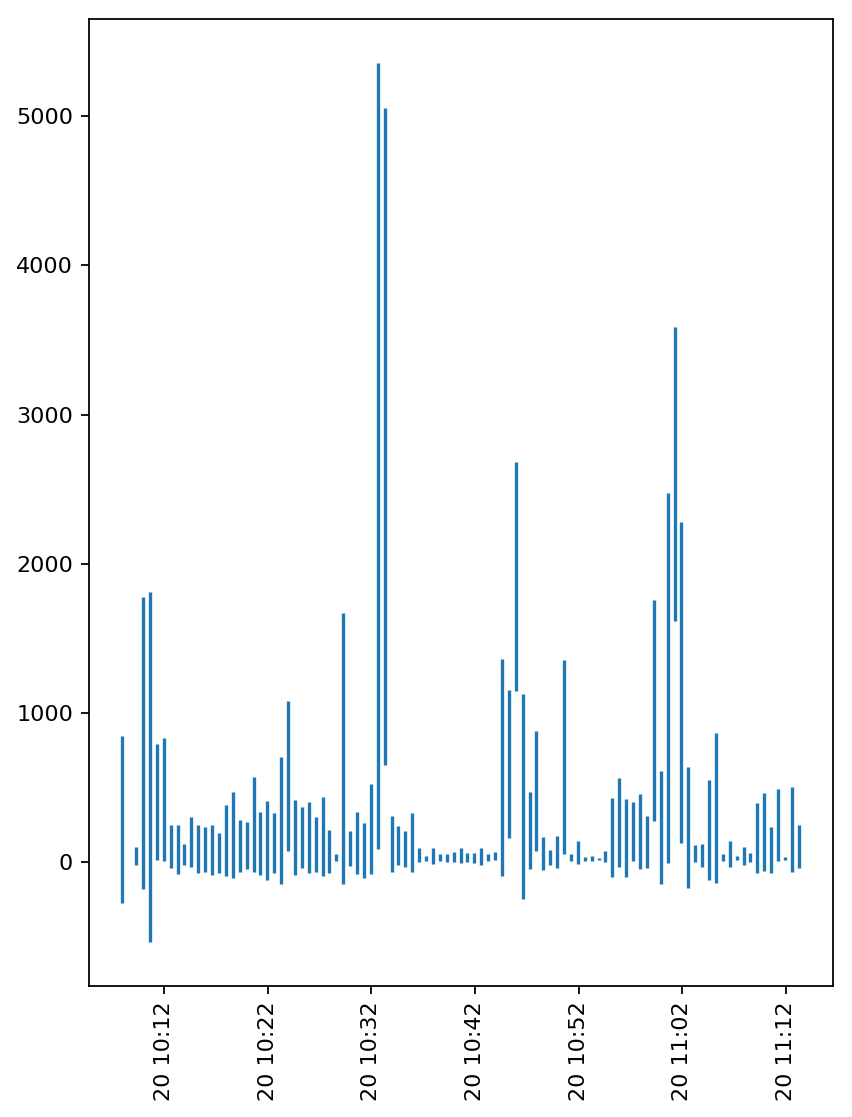

In [159]:
ts = get_profile_timeseries(df['timestamp'],df['ping_time'])
fig,ax = plt.subplots(figsize=(6,8),dpi=160)
ax.errorbar(ts['timestamp'],ts['mean'],yerr=ts['stdev'],linestyle='None')
plt.xticks(rotation='vertical')
plt.show()